In [116]:
#Projet

## Question 1

*Approximate the integral of f using standard Monte Carlo and quasi-Monte Carlo,
and compare the results, for different values of d (and different Monte Carlo sample
sizes!).*

**A. Monte-Carlo standard**

In [117]:
#!pip install qmcpy

In [2]:
import time
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats.qmc import Sobol

In [32]:
#Fonction target

def f(u):
    d = u.shape[1] 
    return 1 + np.sin(2 * np.pi * (1/d * np.sum(u, axis = 1) - 1/2))

def f2D(u,v):
    d = u.shape[1] 
    return 1 + np.sin(2 * np.pi * (1/d * (u+v) - 1/2))

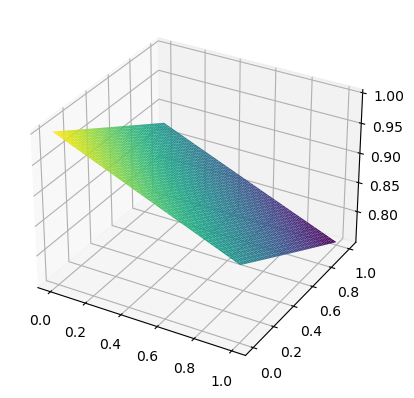

In [33]:
x1 = np.linspace(0, 1, num=50)
x2 = np.linspace(0, 1, num=50)
x3 = np.linspace(0, 1, num=50)
X1, X2 = np.meshgrid(x1, x2)
Z = f2D(X1, X2)
fig = plt.figure()
ax = fig.add_subplot(projection='3d') # pour un graphe en 3D
ax.plot_surface(X1, X2, Z, cmap='viridis')
plt.show()


In [34]:
#Estimation de l'intégrale par la méthode de Monte Carlo standard

def MonteCarlo(f,N,d):
    x = np.random.rand(N, d)
    integral = np.sum(f(x))/N
    return(integral)

In [35]:
MonteCarlo(f, N = 10000000, d = 3)

1.0000375355909994

**B. Quasi Monte-Carlo**

In [36]:
#Estimation de l'intégrale par la méthode de Quasi Monte Carlo 

def QuasiMonteCarlo(f, N, d):
    sobol = Sobol(d) #Génération des points quasi-aléatoires avec la méthode Sobol
    u = sobol.random(n=N) #Génération des points quasi-aléatoires
    integral = np.sum(f(u))/N #Calcul de l'intégrale approximative
    return(integral)

QuasiMonteCarlo(f, N = 10000000, d = 3)

0.9999999474178128

**C. Comparaison**

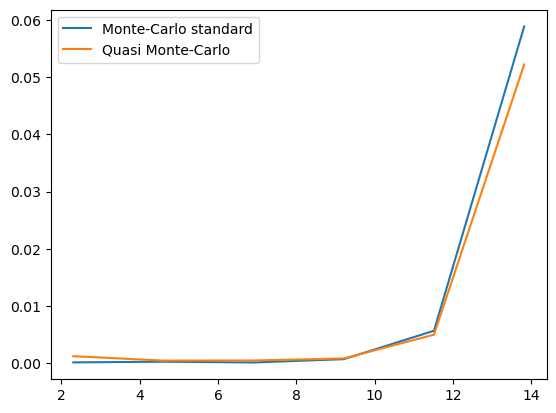

In [37]:
#Temps de calcul
NN = np.array([10, 100, 1000, 10000, 100000, 1000000])

tempsMCstandard = []
tempsQMC = []

for n in NN :
    start_time = time.time()
    MonteCarlo(f, N = n, d = 3) #Appel de la fonction
    end_time = time.time()
    tempsMCstandard.append(end_time - start_time)
    
    start_time = time.time()
    QuasiMonteCarlo(f, N = n, d = 3) #Appel de la fonction
    end_time = time.time()
    tempsQMC.append(end_time - start_time)

plt.plot(np.log(NN),tempsMCstandard)
plt.plot(np.log(NN),tempsQMC)
plt.legend(['Monte-Carlo standard', 'Quasi Monte-Carlo'])


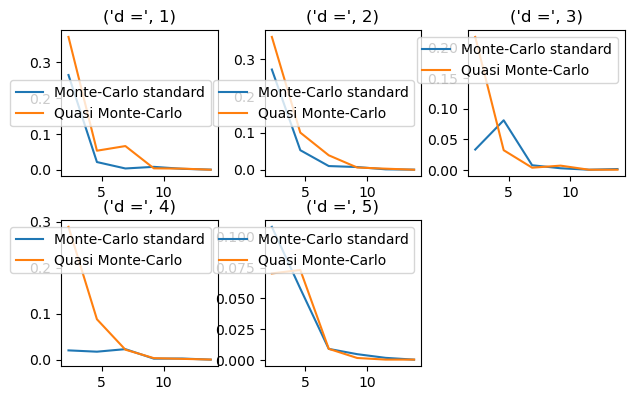

In [38]:
#Précision
NN = np.array([10, 100, 1000, 10000, 100000, 1000000])
DD = np.arange(1,6)

l = 1
for d in DD:
    precisionMCstandard = []
    precisionQMC = []
    for n in NN :
        y_predict = MonteCarlo(f, N = n, d = d) #Appel de la fonction
        precisionMCstandard.append(np.abs(1-y_predict))

        y_predict = MonteCarlo(f, N = n, d = d) #Appel de la fonction
        precisionQMC.append(np.abs(1-y_predict))
    
    plt.subplot(2,3,l)
    plt.plot(np.log(NN),precisionMCstandard)
    plt.plot(np.log(NN),precisionQMC)
    plt.legend(['Monte-Carlo standard', 'Quasi Monte-Carlo'])
    plt.title(('d =', d))
    l+=1

plt.gcf().subplots_adjust(left = 0.02, bottom = 0.2, right = 0.9, top = 0.9, wspace = 0.3, hspace = 0.3)
#plt.figure(figsize = (20, 10))

In [39]:
#comparaisons à améliorer

## Question 2

*Read the introduction of the following paper https://arxiv.org/abs/2210.01554
up to Equations (5) and (6), which introduce Haber’s estimators of order 1 and
2. Implement these two estimators, and compare to the results of Step 1. (Again
consider different values of d and N, where N is the number of evalations of f).*

In [40]:
import numpy as np
from scipy.integrate import nquad

In [69]:
d = 3
#bornes d'intégration
limits = [(0,1)]*d
#nb de cellules
n_cells = 5
#taille des cellules
cell_size = [(lim[1]-lim[0])/n_cells for lim in limits]

In [70]:
#calcul des coordonnées des centres de chaque cellule
grid = np.meshgrid(*[np.linspace(lim[0]+cell_size[i]/2, lim[1]-cell_size[i]/2, n_cells) for i, lim in enumerate(limits)])
cell_centers = np.array([g.ravel() for g in grid]).T
#évaluation de la fonction f en chaque centre c
f_values = f(cell_centers)

In [71]:
#estimation de l'intégrale par l'estimateur d'Haber
integral = np.sum(f_values * np.prod(cell_size)) # ou : np.mean(f_values) * np.prod(cell_size) * n_cells ** len(limits)
integral

1.0000000000000004

In [ ]:
#pas sure de l'estimateur, à relire